In [1]:
from sklearn.datasets import fetch_openml

import pandas as pd
import numpy as np
from scipy import sparse

import networkx as nx
import community as community_louvain
from cdlib import algorithms

import matplotlib as mpl
import matplotlib.pyplot as plt

import umap
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [2]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.neighbors import DistanceMetric

Data Load

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [4]:
X = mnist["data"]
y = mnist["target"]

# Eploratory Analysis

## Plot images

In [5]:
def plot_images(images, labels=None, size=(28,28)):
    images_per_row = min(len(images), 5)
    images = [image.reshape(size[0],size[1]) for image in images]

    n_rows = (len(images) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(images)
    for empty in range(n_empty):
        images.append(np.zeros((size[0], size[1])))
    
    fig, axs = plt.subplots(n_rows, images_per_row, figsize = (6, 3))
    for i, ax in enumerate(axs.flat):
        ax.matshow(images[i], cmap = mpl.cm.binary)
        ax.axis('off')
        if labels and len(labels) > i:
            ax.set_title(f'T:{labels[i][0]}, A:{labels[i][1]}', y=0.8)
        else:
            ax.set_title("")
    plt.show()

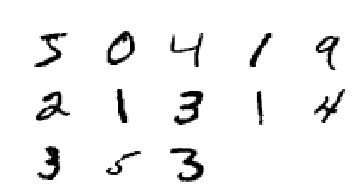

In [6]:
plot_images(X[:13])

Quick look at the data

In [7]:
X.shape

(70000, 784)

## Other utility functions

Function for UMAP dimensionality reduction.

In [8]:
def reduce_dimensionality(array, n_components=15):
    model = umap.UMAP(random_state=42, n_components=n_components, metric="cosine")
    reduced_dim_vec = model.fit_transform(array)
    vectors_list = np.array_split(reduced_dim_vec, len(reduced_dim_vec))
    return pd.Series(vectors_list).apply(lambda x: x.squeeze())

Function for clustering data with DBSCAN.

In [ ]:
def dbscan_clusteriser(vectors:pd.Series, eps=0.25, min_samples=8):
    vectors = np.stack(np.array(vectors))
    model = DBSCAN(eps=eps,min_samples=min_samples)
    model.fit(vectors)
    return pd.Series(model.labels_)

Function for creating a graph.

In [10]:
def create_graph(vectors:pd.Series, threshold=None):
    vector_list = vectors.tolist()   #Parse pandas.Series to list
    W_sparse = sparse.csr_matrix(np.asarray(vector_list))  #Create Compress Sparse Row matrix
    cos_sim = cosine_similarity(W_sparse)   #Calculate cosine similarity between all nodes
    if threshold == None: 
        threshold = np.quantile(cos_sim.flatten(), [0.92])[0]   #Set up a threshold based on percentile
    print(threshold)
    adj_matrix = (cos_sim > threshold).astype(int)   #Create adjacency matrix based on threshold
    adj_matrix = adj_matrix * cos_sim   #Add weights to adjecency matrix
    g = nx.convert_matrix.from_numpy_array(adj_matrix)   #Create a graph
    print(nx.info(g))
    return g

Function for clustering data with Louvain algorithm.

In [11]:
def louvain_clusteriser(vectors:pd.Series, threshold=None):
    g = create_graph(vectors, threshold)
    partition = community_louvain.best_partition(g)
    return pd.Series(list(partition.values()))

Function for clustering the data with Newman's leading igenvector method.

In [ ]:
def eigenvector_clusteriser(vectors:pd.Series, threshold=None):
    g = create_graph(vectors, threshold)
    print(nx.info(g))
    comms = algorithms.eigenvector(g)
    comms = comms.communities
    comms = dict(sorted({item:list_id for list_id, l in enumerate(comms) for item in l}.items()))
    return pd.Series(comms)

Function for assigning a label to a cluster based on the most common true label in a cluster.

In [13]:
def map_to_most_common(df: pd.DataFrame):
    df["cluster"] = df["cluster"].fillna(-1)   #Some algorithms returns -1 when they don't find a community for a node.
    #Create a pandas.Series where index is a cluster's label provided by algorithm and values are true labels
    mappings_series = df.groupby(["cluster", "class"]).agg(lambda x: len(x)).groupby(["cluster"]).apply(lambda x: x.idxmax(axis="columns")[1])
    mappings = dict(mappings_series)
    df["mapped_cluster"] = df["cluster"].apply(lambda x: mappings[x])
    return df

Function for drawing graphs.

In [14]:
def draw_graph(g, colours_map, cluster_colors_list):
    f = plt.figure(1, figsize=(8, 6))
    ax = f.add_subplot(1,1,1)
    for node_id in colours_map.keys():
        ax.plot([1],[0],color=colours_map[node_id],label=node_id)
    nx.draw_kamada_kawai(g, node_color=cluster_colors_list, with_labels=False, ax=ax)
    plt.axis('off')
    plt.legend()
    plt.show()

# Algorithms

## 500 set

In [15]:
X_train = X[:500]

Reduce dimensionality to 15 dimensions.

In [16]:
X_reduced = reduce_dimensionality(X_train)

### DBSCAN

In [17]:
clustered_dbscan_data = dbscan_clusteriser(X_reduced, eps=0.45, min_samples=5)

In [18]:
dbscan_df = pd.DataFrame(y[:500], columns = ["class"])
dbscan_df["cluster"] = clustered_dbscan_data

Map clusters ids to numbers based on frequency - cluster represents the most frequently appearing value in it.

In [19]:
dbscan_df = map_to_most_common(dbscan_df)

In [20]:
print("Accuracy:")
accuracy_score(dbscan_df["class"], dbscan_df["mapped_cluster"])

Accuracy:


0.688

In [21]:
print("NMI:")
normalized_mutual_info_score(dbscan_df["class"], dbscan_df["mapped_cluster"])

NMI:


0.6975225937613211

Number of unique classes identified by algorithm.

In [22]:
print("Number of unique classes:")
dbscan_df["cluster"].nunique()

Number of unique classes:


11

### Louvain algorithm

In [23]:
clustered_louvain_data = louvain_clusteriser(X_reduced)

0.9980971598625182
Name: 
Type: Graph
Number of nodes: 500
Number of edges: 10250
Average degree:  41.0000


In [24]:
louvain_df = pd.DataFrame(y[:500], columns=["class"])
louvain_df["cluster"] = clustered_louvain_data

Map clusters ids to numbers based on frequency - cluster represents the most frequently appearing value in it.

In [25]:
louvain_df = map_to_most_common(louvain_df)

In [26]:
print("Accuracy:")
accuracy_score(louvain_df["class"], louvain_df["mapped_cluster"])

Accuracy:


0.756

In [27]:
print("NMI:")
normalized_mutual_info_score(louvain_df["class"], louvain_df["mapped_cluster"])

NMI:


0.6983668498862557

Number of unique classes identified by algorithm.

In [28]:
print("Number of unique classes:")
louvain_df["cluster"].nunique()

Number of unique classes:


11

### Newman’s leading eigenvector algorithm

In [29]:
clustered_eigenvector_data = eigenvector_clusteriser(X_reduced, threshold=0.9983)

0.9983
Name: 
Type: Graph
Number of nodes: 500
Number of edges: 9628
Average degree:  38.5120


In [30]:
eigenvector_df = pd.DataFrame(y[:500], columns=["class"])
eigenvector_df["cluster"] = clustered_eigenvector_data

Map clusters ids to numbers based on frequency - cluster represents the most frequently appearing value in it.

In [31]:
eigenvector_df = map_to_most_common(eigenvector_df)

In [32]:
print("Accuracy:")
accuracy_score(eigenvector_df["class"], eigenvector_df["mapped_cluster"])

Accuracy:


0.744

In [33]:
print("NMI:")
normalized_mutual_info_score(eigenvector_df["class"], eigenvector_df["mapped_cluster"])

NMI:


0.7007758355643752

Number of unique classes identified by algorithm.

In [34]:
print("Number of unique classes:")
eigenvector_df["cluster"].nunique()

Number of unique classes:


10

## 20 000 set

In [35]:
X_train = X[:20000]

Reduce dimensionality to 15 dimensions.

In [36]:
X_reduced = reduce_dimensionality(X_train)

### DBSCAN

In [37]:
clustered_dbscan_data = dbscan_clusteriser(X_reduced, eps=0.24, min_samples=8)

In [38]:
dbscan_df = pd.DataFrame(y[:20000], columns = ["class"])
dbscan_df["cluster"] = clustered_dbscan_data

Map clusters ids to numbers based on frequency - cluster represents the most frequently appearing value in it.

In [39]:
dbscan_df = map_to_most_common(dbscan_df)

In [40]:
print("Accuracy:")
accuracy_score(dbscan_df["class"], dbscan_df["mapped_cluster"])

Accuracy:


0.6947

In [41]:
print("NMI:")
normalized_mutual_info_score(dbscan_df["class"], dbscan_df["mapped_cluster"])

NMI:


0.7995275021103985

Number of unique classes identified by algorithm.

In [42]:
print("Number of unique classes:")
dbscan_df["cluster"].nunique()

Number of unique classes:


10

### Louvain algorithm

In [51]:
clustered_louvain_data = louvain_clusteriser(X_reduced, threshold=0.9991)

0.9991
Name: 
Type: Graph
Number of nodes: 20000
Number of edges: 5671546
Average degree: 567.1546


In [52]:
louvain_df = pd.DataFrame(y[:20000], columns=["class"])
louvain_df["cluster"] = clustered_louvain_data

Map clusters ids to numbers based on frequency - cluster represents the most frequently appearing value in it.

In [53]:
louvain_df = map_to_most_common(louvain_df)

In [54]:
print("Accuracy:")
accuracy_score(louvain_df["class"], louvain_df["mapped_cluster"])

Accuracy:


0.9468

In [55]:
print("NMI:")
normalized_mutual_info_score(louvain_df["class"], louvain_df["mapped_cluster"])

NMI:


0.8900186822294078

Number of unique classes identified by algorithm.

In [56]:
print("Number of unique classes:")
louvain_df["cluster"].nunique()

Number of unique classes:


10

### Newman’s leading eigenvector algorithm

In [43]:
clustered_eigenvector_data = eigenvector_clusteriser(X_reduced, threshold=0.9991)

0.9991
Name: 
Type: Graph
Number of nodes: 20000
Number of edges: 5671546
Average degree: 567.1546


In [44]:
eigenvector_df = pd.DataFrame(y[:20000], columns=["class"])
eigenvector_df["cluster"] = clustered_eigenvector_data

Map clusters ids to numbers based on frequency - cluster represents the most frequently appearing value in it

In [45]:
eigenvector_df = map_to_most_common(eigenvector_df)

Accuracy on the 20000 set

In [46]:
print("Accuracy:")
accuracy_score(eigenvector_df["class"], eigenvector_df["mapped_cluster"])

Accuracy:


0.95215

In [47]:
print("NMI:")
normalized_mutual_info_score(eigenvector_df["class"], eigenvector_df["mapped_cluster"])

NMI:


0.8940776287067138

Number of unique classes identified by algorithm

In [48]:
print("Number of unique classes:")
eigenvector_df["cluster"].nunique()

Number of unique classes:


10

Accuracy on the first set composed of 500 images

In [49]:
print("Accuracy:")
accuracy_score(eigenvector_df["class"][:500], eigenvector_df["mapped_cluster"][:500])

Accuracy:


0.944

In [50]:
print("NMI:")
normalized_mutual_info_score(eigenvector_df["class"][:500], eigenvector_df["mapped_cluster"][:500])

NMI:


0.8971243390617011

# Wrongly assigned classes

In [57]:
vectors_df = eigenvector_df.copy()
vectors_df["vectors"] = pd.Series(list(X))
vectors_df["reduced_vectors"] = pd.Series(list(X_reduced))

In [58]:
wrong_df = vectors_df[vectors_df["mapped_cluster"] != vectors_df["class"]]

Plot with images of wrongly assigned classes.

T - true labels

A - Assigned labels

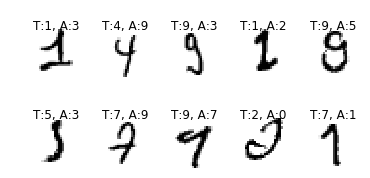

In [59]:
plot_images(wrong_df["vectors"].iloc[:10], labels=list(zip(wrong_df["class"], wrong_df["mapped_cluster"])))

Plot of reduced images with wrongly assigned classes.

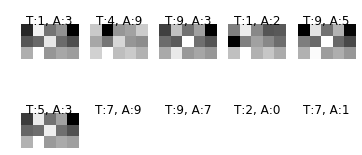

In [60]:
plot_images(wrong_df["reduced_vectors"].iloc[:6], labels=list(zip(wrong_df["class"], wrong_df["mapped_cluster"])),size=(3,5))

# Graph visualisation

In [61]:
low, *_, high = sorted(eigenvector_df["cluster"].unique())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)

In [62]:
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
colours = mapper.to_rgba([i for i in eigenvector_df["cluster"].unique()])

In [63]:
colours_map = {i: colours[i] for i in eigenvector_df["cluster"].unique()}
colours_map = dict(sorted(colours_map.items()))

In [64]:
n_plot_nodes = 500

In [65]:
cluster_colors_list = eigenvector_df["mapped_cluster"][:n_plot_nodes].apply(lambda x: colours_map[x])
true_colors_list = eigenvector_df["class"][:n_plot_nodes].apply(lambda x: colours_map[x])

In [66]:
g = create_graph(X_reduced[:n_plot_nodes], threshold=0.9991)

0.9991
Name: 
Type: Graph
Number of nodes: 500
Number of edges: 4317
Average degree:  17.2680


### Plot ground true labels

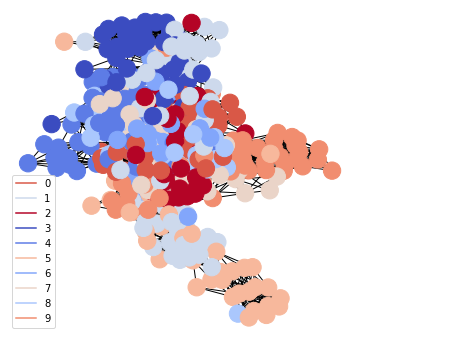

In [67]:
draw_graph(g, colours_map, true_colors_list)

### Plot assigned labels

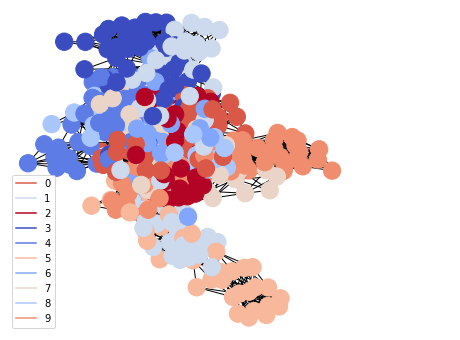

In [68]:
draw_graph(g, colours_map, cluster_colors_list)

## Plot graph evolution

0.9991
Name: 
Type: Graph
Number of nodes: 10
Number of edges: 11
Average degree:   2.2000


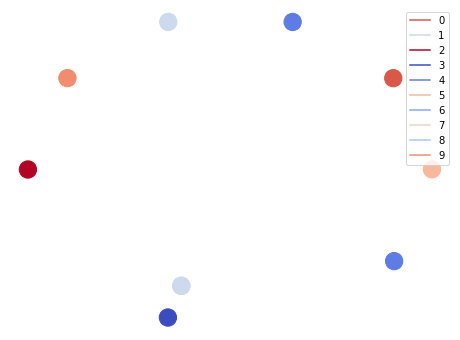

0.9991
Name: 
Type: Graph
Number of nodes: 20
Number of edges: 24
Average degree:   2.4000


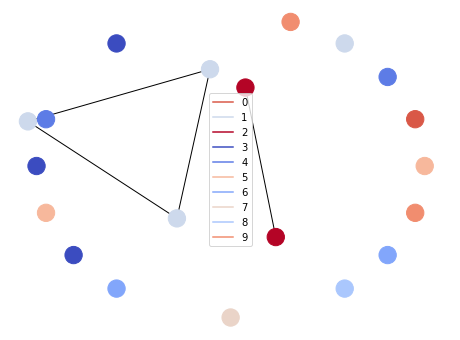

0.9991
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 42
Average degree:   2.8000


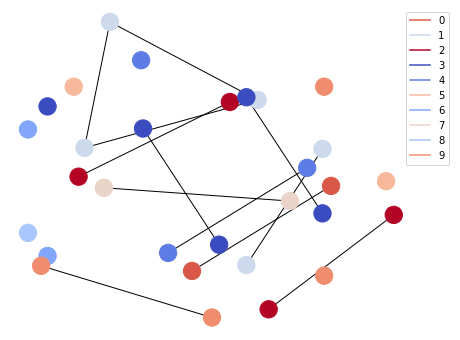

0.9991
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 66
Average degree:   3.3000


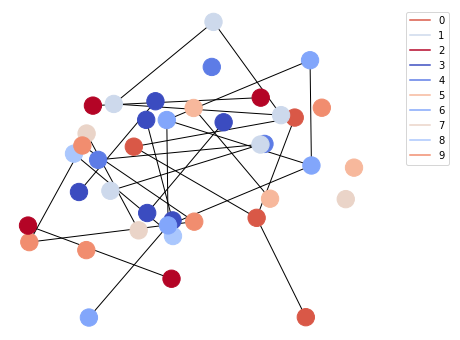

0.9991
Name: 
Type: Graph
Number of nodes: 50
Number of edges: 88
Average degree:   3.5200


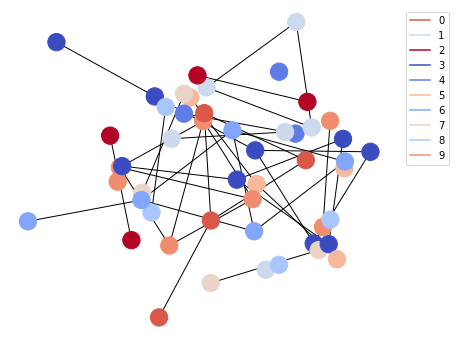

0.9991
Name: 
Type: Graph
Number of nodes: 60
Number of edges: 114
Average degree:   3.8000


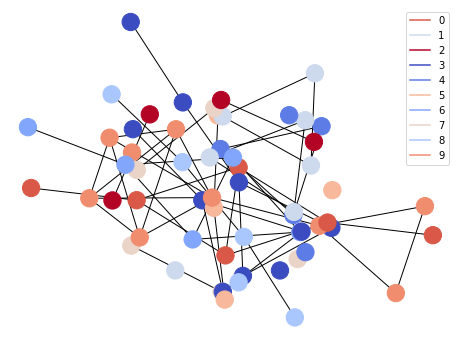

0.9991
Name: 
Type: Graph
Number of nodes: 70
Number of edges: 139
Average degree:   3.9714


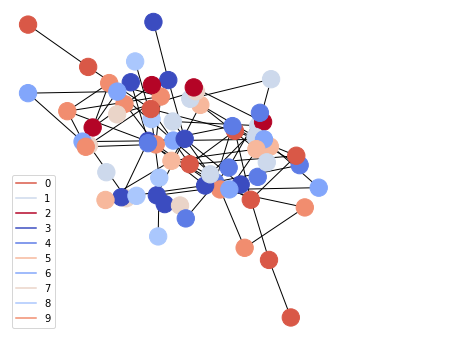

0.9991
Name: 
Type: Graph
Number of nodes: 80
Number of edges: 177
Average degree:   4.4250


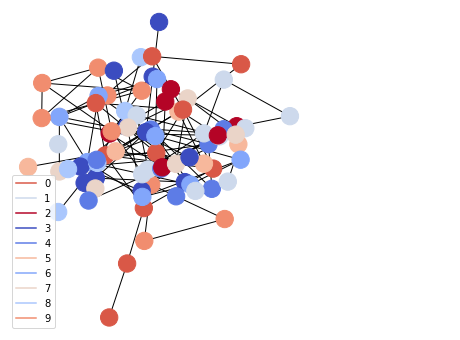

0.9991
Name: 
Type: Graph
Number of nodes: 90
Number of edges: 217
Average degree:   4.8222


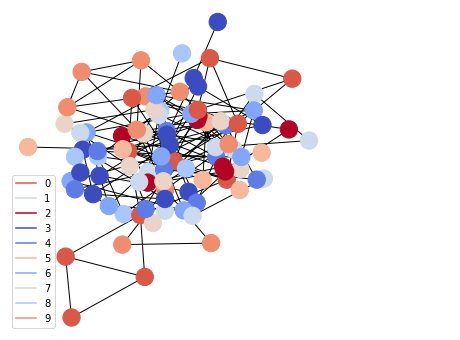

In [70]:
for n_plot_nodes in range(10, 100, 10):
    cluster_colors_list = eigenvector_df["mapped_cluster"][:n_plot_nodes].apply(lambda x: colours_map[x])
    true_colors_list = eigenvector_df["class"][:n_plot_nodes].apply(lambda x: colours_map[x])
    g = create_graph(X_reduced[:n_plot_nodes], threshold=0.9991)
    draw_graph(g, colours_map, cluster_colors_list)